# Allow list approach with image redaction
This notebook covers how to use the `allow_list` argument to prevent certain words from being redacted from images and explains how you can use this to implement a strict redact all text approach.

## Prerequisites
Before getting started, make sure presidio and the latest version of Tesseract OCR are installed. For detailed documentation, see the [installation docs](https://microsoft.github.io/presidio/installation).

In [ ]:
!pip install presidio_analyzer presidio_anonymizer presidio_image_redactor
!python -m spacy download en_core_web_lg

## Imports

In [1]:
from PIL import Image
import pydicom
from presidio_image_redactor import ImageRedactorEngine, DicomImageRedactorEngine
import matplotlib.pyplot as plt

## Example Images
In this notebook, we will use the following examples images. Here we see the images prior to any redaction.

### Standard example image

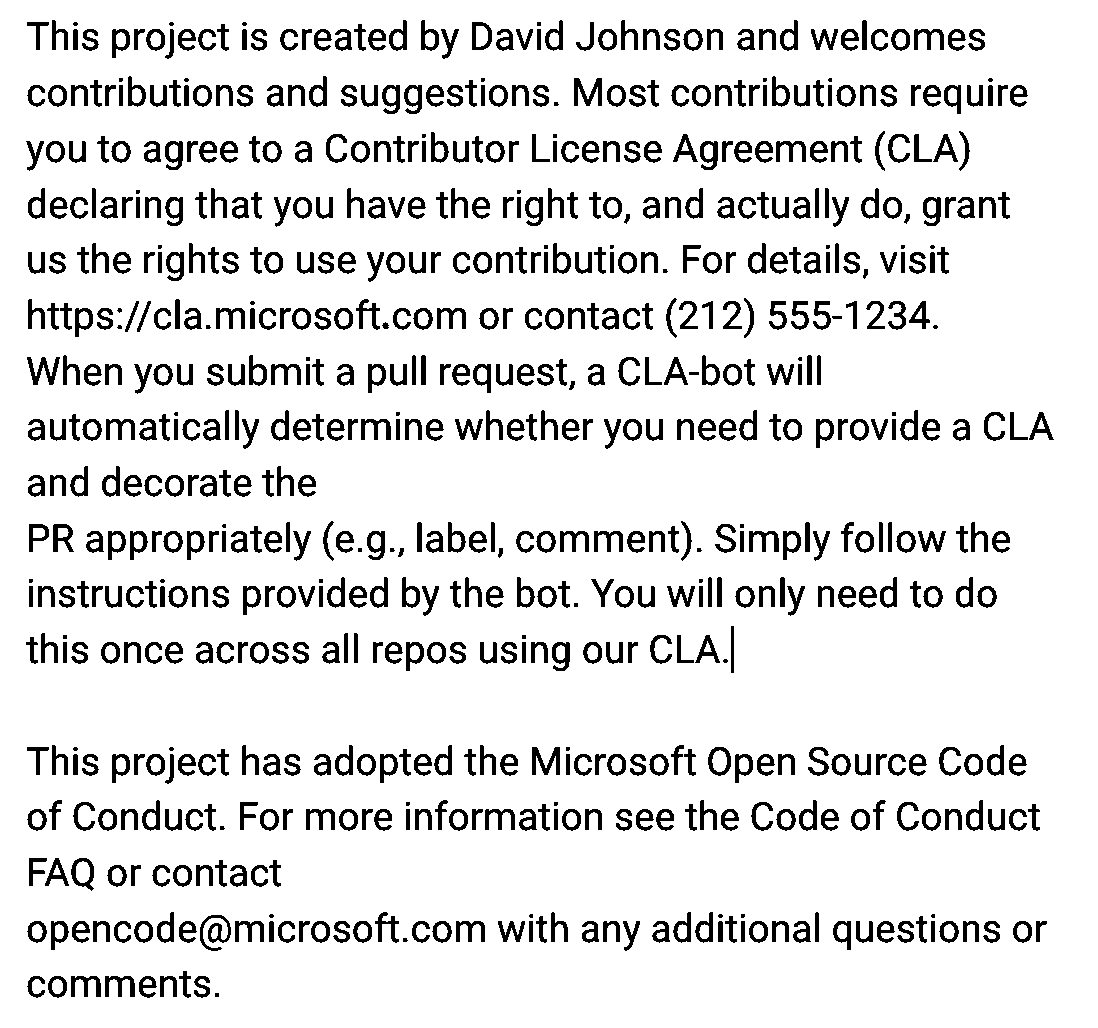

In [4]:
image = Image.open("../../image-redactor/ocr_text.png")
display(image)

### DICOM medical image
For more information on DICOM image redaction, please see [example_dicom_image_redactor.ipynb](./example_dicom_image_redactor.ipynb) and the [Image redactor module documentation](../../../image-redactor/index.md).

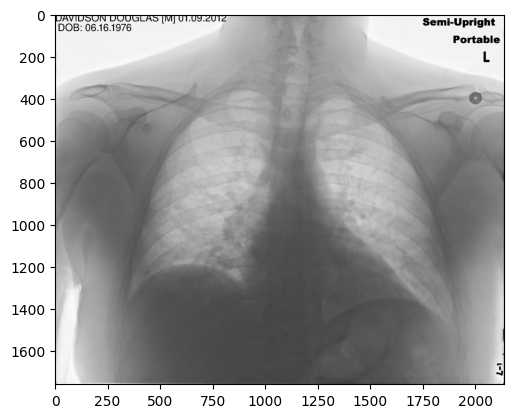

In [7]:
instance = pydicom.dcmread("./sample_data/0_ORIGINAL.dcm")
plt.imshow(instance.pixel_array, cmap="gray")

## Scenario 1: Prevent some words from being redacted
Whether using the default recognizer, registering your own custom recognizer, or using ad-hoc recognizers to identify sensitive entities, there may be times where you **do not** want certain words redacted.

In these cases, we can use the `allow_list` argument passed into the `ImageAnalyzerEngine` via our redact engine to preserve specified strings.

### Standard images

In [8]:
# Initialize the engine
engine = ImageRedactorEngine()

Redacted image without using allow list

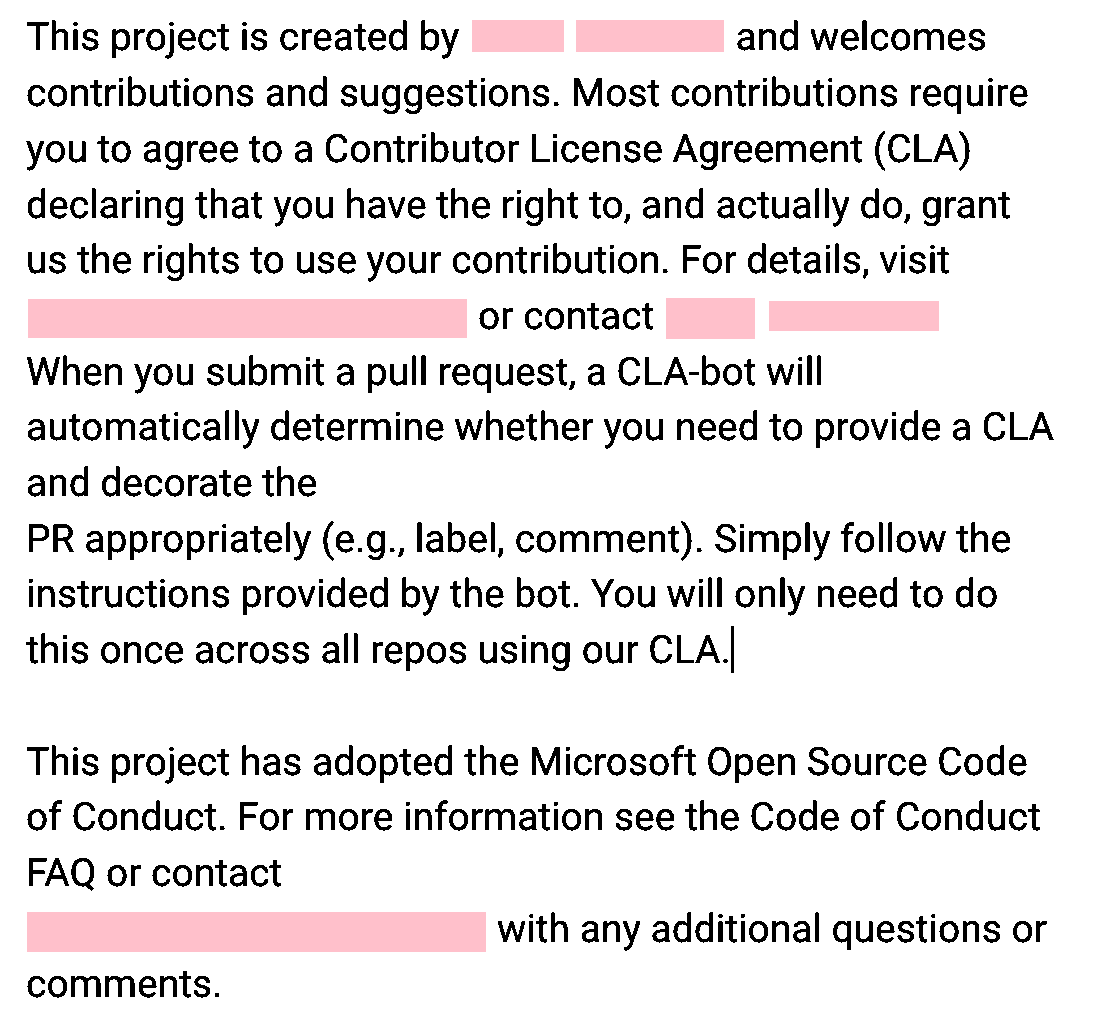

In [9]:
redacted_image = engine.redact(image, (255, 192, 203))
display(redacted_image)

Redacted image when using the allow list approach

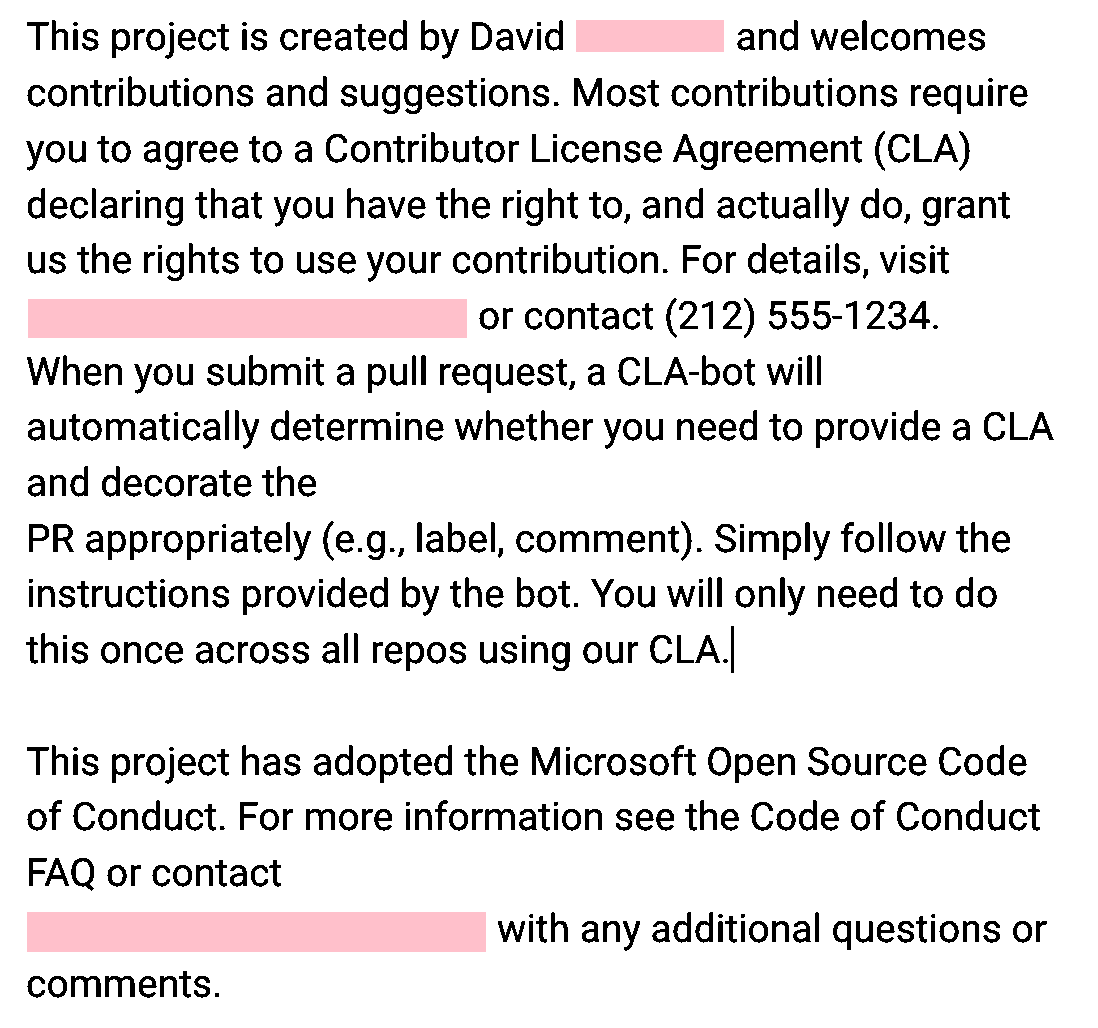

In [12]:
redacted_image = engine.redact(image, (255, 192, 203), allow_list=["David", "(212) 555-1234"])
display(redacted_image)

### DICOM images
This approach, as well as all other approaches demonstrated in this notebook, can also be used with DICOM medical images.

In [13]:
# Initialize
dicom_engine = DicomImageRedactorEngine()
padding_width = 3
fill = "background"

Redacted image without using the allow list

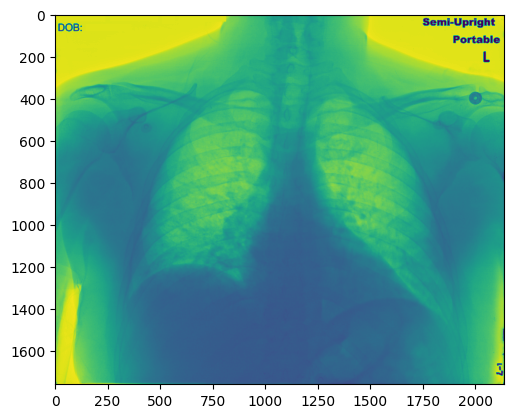

In [14]:
results = dicom_engine.redact(instance, padding_width=padding_width, fill=fill)
plt.imshow(results.pixel_array)

Redacted image when using the allow list approach

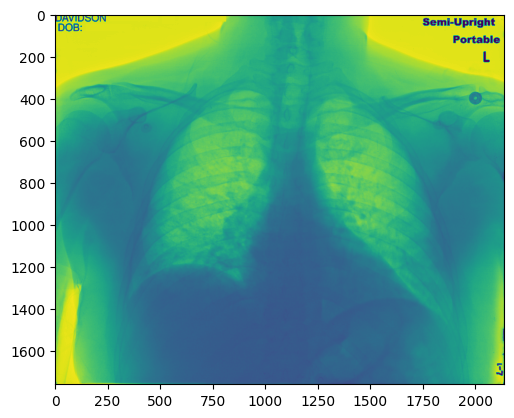

In [15]:
# Redact
results = dicom_engine.redact(instance, padding_width=padding_width, fill=fill, allow_list=["DAVIDSON"])
plt.imshow(results.pixel_array)

## Scenario 2: Only allow specific words while redacting all other text
In some cases, we want to preserve certain words and redact all other text in the image. We can create an ad-hoc recognizer that considers all text as sensitive and couple that with the allow list.

In [ ]:
# will add once PR 1113 is merged in

In [ ]:
# add in preprocessing method to augment allow list
# add appending a period or any sort of punctuation to words in augmentation

## Scenario 3: Redact all text on the image
When it is critical to minimize False Negatives during the redaction process, we recommend using a "redact all" approach to redact all detected text.

> *Note: As with the other scenarios, good OCR performance is critical in ensuring the analyzer can pick up on all text in the image. False Negatives may still occur with images if the OCR fails to pick up on all the text.*

In [ ]:
# will add once PR 1113 is merged in